In [ ]:
!pip install torchinfo
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/h.2026_예비대학/dogs-vs-cats.zip"

Archive:  /content/gdrive/MyDrive/Colab Notebooks/h.2026_예비대학/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip "/content/train.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: t

In [ ]:
# Module import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim import Adam
import torchmetrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import albumentations as A

from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from PIL import Image

# EDA

In [ ]:
import pandas as pd

submit_df = pd.read_csv("/content/sampleSubmission.csv")

In [ ]:
import os
from sklearn.model_selection import train_test_split

image_paths = []
labels = []
for dirname, _, filenames in os.walk("/content/train"):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        image_paths.append(image_path)

        if 'cat' in image_path:
            labels.append('cat')
        elif 'dog' in image_path:
            labels.append('dog')
        else:
            labels.append('None')

cat_dog_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
})

label_to_id = {
    'cat': 0,
    'dog': 1
}

id_to_label = {
    0: 'cat',
    1: 'dog'
}

cat_dog_df['label'] = cat_dog_df['label'].map(label_to_id)
train_df, test_df = train_test_split(cat_dog_df, stratify=cat_dog_df['label'], test_size=0.1)
train_df, val_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.2)

train_df.shape, val_df.shape, test_df.shape

((18000, 2), (4500, 2), (2500, 2))

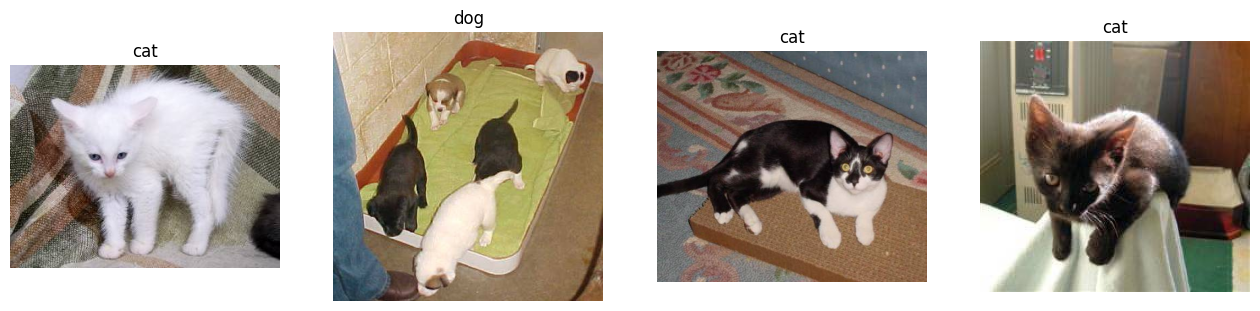

In [ ]:
def show_image(image_paths, labels=None, ncols=4):
    fig, axes = plt.subplots(figsize=(16, 8), ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(id_to_label[labels[i]])
        axes[i].axis('off')

show_image(train_df['image_path'].values[:4], train_df['label'].values[:4])

# 모델 생성

In [ ]:
# 사전학습된 모델을 만드는 함수(create pretrained model function)
# 모든 가중치는 DEFAULT로 선언(all weights = 'DEFAULT')
def create_pretrained_model(model_name='alexnet', classifier_layer=None, image_size=[224, 224], make_summary=False):
    if model_name == 'alexnet':
        model = models.alexnet(weights='DEFAULT')
        model.classifier = classifier_layer
    elif model_name == 'resnet50':
        model = models.resnet50(weights='DEFAULT')
        model.fc = classifier_layer
    elif model_name == 'resnet101':
        model = models.resnet101(weights='DEFAULT')
        model.fc = classifier_layer
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='DEFAULT')
        model.classifier = classifier_layer
    elif model_name == 'efficientnet_b4':
        model = models.efficientnet_b4(weights='DEFAULT')
        model.classifier = classifier_layer
    elif model_name == 'efficientnet_v2_s':
        model = models.efficientnet_v2_s(weights='DEFAULT')
        model.classifier = classifier_layer
    elif model_name == 'efficientnet_v2_m':
        model = models.efficientnet_v2_m(weights='DEFAULT')
        model.classifier = classifier_layer
    elif model_name == 'efficientnet_v2_l':
        model = models.efficientnet_v2_l(weights='DEFAULT')
        model.classifier = classifier_layer
    elif model_name == 'convnext_base':
        model = models.convnext_base(weights='DEFAULT')
        model.classifier[2] = classifier_layer
    elif model_name == 'convnext_small':
        model = models.convnext_small(weights='DEFAULT')
        model.classifier[2] = classifier_layer
    else:
        print("🧨🧨 [ERROR] 모델 이름이 존재하지 않습니다. 🧨🧨")
        return None

    if make_summary:
        # 모델 정보 요약(model summary)
        print(torchinfo.summary(model, input_size=[1, 3] + image_size,
                  col_names=['output_size', 'num_params', 'trainable'],
                  row_settings=['depth', 'var_names'],
                  depth=3))

    return model

classifier_layer = nn.Sequential(
    nn.Linear(in_features=1280, out_features=2),
)

eff_model = create_pretrained_model(
    model_name = 'efficientnet_b0',
    classifier_layer = classifier_layer,
    make_summary=True
    )

Layer (type (var_name):depth-idx)                                 Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                       [1, 2]                    --                        True
├─Sequential (features): 1-1                                      [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0): 2-1                              [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0): 3-1                                       [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1): 3-2                                  [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2): 3-3                                         [1, 32, 112, 112]         --                        --
│    └─Sequential (1): 2-2                                        [1, 16, 112, 112]         --                        True
│    │    └─M

# Custom_Dataset 생성

In [ ]:
# CNN Dataset
class Custom_Dataset(Dataset):
    # 여기서 transform은 albumentations transform이라고 가정.
    # 모든 image는 OpenCV로 다룸.
    # 따라서 마지막에 last channel -> first channel로 바꿔주는 로직이 별도로 필요.
    def __init__(self, image_paths, targets=None, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform

    # 전체 건수 반환
    def __len__(self):
        return len(self.image_paths)

    # 주요 메커니즘
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # image는 ndarry.
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

        # albumentation 별도 적용.
        # albumentation에서 ToTensorV2를 별도로 적용.
        # 사실 이 로직이 작동하지 않으면 오류 발생.
        if self.transform is not None:
            image = self.transform(image=image)['image']

        if self.targets is not None:
            target = torch.tensor(self.targets[idx])
            return image, target
        else:
            return image

In [ ]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

In [ ]:
train_dataset = Custom_Dataset(train_df['image_path'].values, train_df['label'].values, transform=train_transform)
val_dataset = Custom_Dataset(val_df['image_path'].values, val_df['label'].values, transform=val_transform)
test_dataset = Custom_Dataset(test_df['image_path'].values, test_df['label'].values, transform=test_transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

In [ ]:
next(iter(train_dataloader))

[tensor([[[[-0.2513, -0.1657, -0.2342,  ..., -1.0048,  0.4166,  0.7591],
           [-0.3369, -0.3027, -0.1314,  ..., -1.2103,  0.9817,  1.2385],
           [-0.3198, -0.3027, -0.1314,  ..., -1.1589,  1.3584,  1.2385],
           ...,
           [-1.9980, -2.0152, -1.9980,  ..., -1.1760, -1.4672, -1.1760],
           [-1.9980, -1.9980, -1.9467,  ..., -0.9705, -1.5185, -1.0562],
           [-1.9638, -1.9980, -1.9980,  ..., -0.6281, -1.5185, -1.0733]],
 
          [[ 0.0126,  0.1527,  0.2052,  ..., -0.8978,  0.3627,  0.6078],
           [-0.0224,  0.0651,  0.2927,  ..., -1.1604,  0.9405,  1.0980],
           [ 0.0476,  0.0826,  0.2927,  ..., -1.1429,  1.3256,  1.1155],
           ...,
           [-1.6331, -1.6155, -1.5805,  ..., -1.0028, -1.3704, -1.1078],
           [-1.6155, -1.6155, -1.5280,  ..., -0.8452, -1.4230, -1.0028],
           [-1.6331, -1.6856, -1.7031,  ..., -0.7402, -1.5980, -1.0203]],
 
          [[-0.3404, -0.2358, -0.2358,  ..., -0.5844,  0.7925,  1.0714],
           [-

# 모델 학습

In [ ]:
# CNN 학습 Class
class Trainer:
    def __init__(self, model=None, train_dataloader=None, val_dataloader=None, loss_fn=None, auc_metric=None, acc_metric=None, optimizer=None):
        self.model = model
        self.val_dataloader = val_dataloader
        self.loss_fn = loss_fn
        self.auc_metric = auc_metric
        self.acc_metric = acc_metric
        self.optimizer = optimizer


    # 1번 에포크 학습 함수(1 epoch train function)
    def train_epoch(self, train_dataloader):
        device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

        self.model = self.model.to(device)
        self.acc_metric = self.acc_metric.to(device)
        self.auc_metric = self.auc_metric.to(device)

        # 평균 loss를 구하기 위한 변수(variable for average loss)
        avg_loss = 0
        sum_loss = 0

        # 모델 학습 설정(model train setting)
        self.model.train()

        with tqdm(total = len(train_dataloader), desc="[Training...] ", leave=True) as progress_bar:
            for batch_idx, (images, labels) in enumerate(train_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                sum_loss += loss.item()
                avg_loss = sum_loss / (batch_idx+1)

                if self.auc_metric is not None:
                    self.auc_metric.update(F.softmax(logits, dim=-1), labels)
                if self.acc_metric is not None:
                    self.acc_metric.update(F.softmax(logits, dim=-1).argmax(dim=-1), labels)

                # 옵티마이저 초기화(optimizer initialize)
                self.optimizer.zero_grad()

                # 오차역전파 계산(backpropagation)
                loss.backward()

                # 학습 파라미터 업데이트(parameter Update)
                self.optimizer.step()

                # Progress bar Update
                progress_bar.update(1)

                if batch_idx % 20 == 0 or batch_idx+1 == len(train_dataloader):
                    # Progress_bar Update -> set_postfix
                    current_auc = self.auc_metric.compute().item()
                    current_acc = self.acc_metric.compute().item()
                    progress_bar.set_postfix({
                        "Train_Loss" : avg_loss,
                        "Train_ACC": current_acc,
                        "Train_AUC" : current_auc,
                        })

            self.auc_metric.reset()
            self.acc_metric.reset()

        return avg_loss, current_acc, current_auc

    # 1번 에포크 학습 함수(1 epoch train function)
    def validate_epoch(self, val_dataloader):
        device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

        self.model = self.model.to(device)
        self.acc_metric = self.acc_metric.to(device)
        self.auc_metric = self.auc_metric.to(device)

        # 평균 loss를 구하기 위한 변수(variable for average loss)
        avg_loss = 0
        sum_loss = 0

        # 모델 평가로 설정(model evaluation setting)
        self.model.eval()

        with torch.no_grad():
            with tqdm(total = len(val_dataloader), desc="[Validating..] ", leave=True) as progress_bar:
                for batch_idx, (images, labels) in enumerate(val_dataloader):
                    images = images.to(device)
                    labels = labels.to(device)

                    logits = self.model(images)
                    loss = self.loss_fn(logits, labels)
                    sum_loss += loss.item()
                    avg_loss = sum_loss / (batch_idx+1)

                    if self.auc_metric is not None:
                        self.auc_metric.update(F.softmax(logits, dim=-1), labels)
                    if self.acc_metric is not None:
                        self.acc_metric.update(F.softmax(logits, dim=-1).argmax(dim=-1), labels)

                    # Progress bar Update
                    progress_bar.update(1)

                    if batch_idx % 20 == 0 or batch_idx+1 == len(val_dataloader):
                        # Progress_bar Update -> set_postfix
                        current_acc = self.acc_metric.compute().item()
                        current_auc = self.auc_metric.compute().item()
                        progress_bar.set_postfix({
                            "Validate_Loss" : avg_loss,
                            "Validate_ACC" : current_acc,
                            "Validate_AUC" : current_auc,
                            })

                self.acc_metric.reset()
                self.auc_metric.reset()

        return avg_loss, current_acc, current_auc

    # fit(train_epochs and val_epochs)
    def fit(self, epochs, train_dataloader=None, val_dataloader=None):
        history = {
            'train_loss' : [],
            'val_loss' : [],
            'train_acc' : [],
            'val_acc' : [],
            'train_auc' : [],
            'val_auc' : [],
        }

        for epoch in range(1, epochs+1):
            if train_dataloader is not None:
                train_loss, train_acc, train_auc = self.train_epoch(train_dataloader)
                history['train_loss'].append(train_loss); history['train_acc'].append(train_acc); history['train_auc'].append(train_auc)
            else:
                print("학습 데이터로더가 존재하지 않음!")
                return history

            if val_dataloader is not None:
                val_loss, val_acc, val_auc = self.validate_epoch(val_dataloader)
                history['val_loss'].append(val_loss); history['val_acc'].append(val_acc); history['val_auc'].append(val_auc)

        return history

    # 모델 평가
    def evaluate(self, eval_dataloader):
        device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

        self.model = self.model.to(device)
        self.acc_metric = self.acc_metric.to(device)
        self.auc_metric = self.auc_metric.to(device)

        # 평균 loss를 구하기 위한 변수(variable for average loss)
        avg_loss = 0
        sum_loss = 0

        # 모델 평가로 설정(model evaluation setting)
        self.model.eval()

        with torch.no_grad():
            with tqdm(total = len(eval_dataloader), desc="[Evaluating..] ", leave=True) as progress_bar:
                for batch_idx, (images, labels) in enumerate(eval_dataloader):
                    images = images.to(device)
                    labels = labels.to(device)


                    logits = self.model(images)
                    loss = self.loss_fn(logits, labels)
                    sum_loss += loss.item()
                    avg_loss = sum_loss / (batch_idx+1)

                    if self.auc_metric is not None:
                        self.auc_metric.update(F.softmax(logits, dim=-1), labels)
                    if self.acc_metric is not None:
                        self.acc_metric.update(F.softmax(logits, dim=-1).argmax(dim=-1), labels)

                    # Progress bar Update
                    progress_bar.update(1)

                    if batch_idx % 20 == 0 or batch_idx+1 == len(eval_dataloader):
                        # Progress_bar Update -> set_postfix
                        current_acc = self.acc_metric.compute().item()
                        current_auc = self.auc_metric.compute().item()
                        progress_bar.set_postfix({
                            "Evaluate_Loss" : avg_loss,
                            "Evaluate_ACC" : current_acc,
                            "Evaluate_AUC" : current_auc,
                            })

                self.acc_metric.reset()
                self.auc_metric.reset()

        return avg_loss, current_acc, current_auc

    # 마지막으로 학습된 모델 반환(return final trained model)
    def get_trained_model(self):
        return self.model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(eff_model.parameters(), lr=0.0001)

auc_metric = torchmetrics.AUROC(task="multiclass", num_classes=2)
acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=2)

trainer =Trainer(
    model=eff_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    auc_metric=auc_metric,
    acc_metric=acc_metric,
    optimizer=optimizer)

In [ ]:
history = trainer.fit(epochs=3, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

[Training...] :   9%|▊         | 97/1125 [00:06<01:05, 15.77it/s, Train_Loss=0.697, Train_ACC=0.538, Train_AUC=0.572]


KeyboardInterrupt: 

In [ ]:
trainer.evaluate(test_dataloader)

# 학습 시각화

In [ ]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.plot(history['train_auc'], label='train_auc')
plt.plot(history['val_auc'], label='val_acu')
plt.legend()
plt.show()

# 모델 추론

In [ ]:
!unzip "/content/test1.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           
  inflating: t

In [ ]:
final_test_image_paths = []

for dirname, _, filenames in os.walk("/content/test1"):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        final_test_image_paths.append(image_path)

final_test_image_paths.sort()

In [ ]:
final_test_dataset = Custom_Dataset(final_test_image_paths, None, test_transform)
final_test_dataloader = DataLoader(final_test_dataset, batch_size=16, shuffle=False, pin_memory=True)

In [ ]:
# CNN 예측 Class
class Predictor:
    def __init__(self, model=None):
        self.model = model

    def predict(self, test_dataloader):
        pred_proba = self.predict_proba(test_dataloader)
        pred = pred_proba.argmax(dim=-1).cpu().numpy()

        return pred

    def predict_proba(self, test_dataloader):
        device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

        pred_probas = []

        self.model.to(device)
        self.model.eval()

        with torch.no_grad():
            with tqdm(total=len(test_dataloader), desc="[Predicting...] ", leave=True) as progress_bar:
                for batch_idx, images in enumerate(test_dataloader):
                    images = images.to(device) # images = images[0].to(device) -> fashion dataset 사용시 이걸로 바꿀 것

                    logit = self.model(images)

                    pred_proba = F.softmax(logit, dim=-1).cpu().numpy()

                    pred_probas.append(pred_proba)
                    progress_bar.update(1)

        final_result = np.concatenate(pred_probas, axis=0)

        return torch.tensor(final_result)


In [ ]:
predictor = Predictor(model=eff_model)

In [ ]:
preds = predictor.predict(final_test_dataloader)

[Predicting...] : 100%|██████████| 782/782 [00:27<00:00, 28.09it/s]


In [ ]:
preds

array([0, 0, 0, ..., 0, 0, 0])

# 파일 제출

In [ ]:
submit_df.head(5)

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
submit_df['label'] = preds

In [ ]:
submit_df.to_csv("/content/submit_df.csv", index=False)